In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdclef-2025/sample_submission.csv
/kaggle/input/birdclef-2025/taxonomy.csv
/kaggle/input/birdclef-2025/train.csv
/kaggle/input/birdclef-2025/recording_location.txt
/kaggle/input/birdclef-2025/train_audio/greani1/XC132190.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/iNat178385.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC257720.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC9313.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC556246.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC445491.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC288545.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC131095.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC711975.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC286574.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/iNat1290457.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC583591.ogg
/kaggle/input/birdclef-2025/train_audio/greani1/XC716613.ogg
/kaggle/input/birdclef-2

# Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Metric

https://www.kaggle.com/code/metric/birdclef-roc-auc

Macro-averaged ROC-AUC is used for evaluation. Macro-averaging means that the ROC-AUC is calculated for each class independently and then averaged across all classes. This ensures that each class contributes equally to the final score, regardless of its frequency.

It implies that we have to build model which is robust to class imbalance. Usage of class weighting losses might be a good idea.

This metric also skips classes which does not have any True Positives - meaning that class needs at least one True Positive sample to affect the final score.

To conclude - our EDA should include insights about minority classes as well.

# Metadata

In [3]:
comp_dir = '/kaggle/input/birdclef-2025'
ss_df = pd.read_csv(os.path.join(comp_dir, 'sample_submission.csv'))
tax_df = pd.read_csv(os.path.join(comp_dir, 'taxonomy.csv'))
train_df = pd.read_csv(os.path.join(comp_dir, 'train.csv'))
with open(os.path.join(comp_dir, "recording_location.txt"), "r") as file:
    recording_location = file.read()

In [4]:
print(recording_location)

Nature reserve "El Silencio" in the municipality of Yondó in the Middle Magdalena Valley of Colombia.

Website: https://www.fundacionbiodiversa.org/fundacion2024/information/  

Coordinates:

Latitude: 6.76
Longitude: -74.21


In [5]:
tax_df.head()

primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta

In [6]:
train_df.head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  
0  cc-by-nc-sa 4.0  
1  cc-by-nc-sa 4.0  
2  cc-by-nc-sa 4.0  
3  cc-by-nc-sa 4.0  
4  cc-by-nc-sa 4.0

In [7]:
train_df = train_df.merge(tax_df[['primary_label', 'inat_taxon_id', 'class_name']], on='primary_label', how='left')
train_df.head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  inat_taxon_id class_name  
0  cc-by-nc-sa 4.0        1139490    Insecta  
1  cc-by-nc-sa 4.0        1139490    Insecta  
2  cc-by-nc-sa 4.0        1192948    Insecta  
3  cc-by-nc-sa 4.0        1192948    Insecta  
4  cc-by-nc-sa 4.0        1192948    Insecta

In [8]:
train_df.shape

(28564, 15)

In [9]:
train_df.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
inat_taxon_id         0
class_name            0
dtype: int64

In [10]:
# Check for duplicates
print('\n',"Duplicates in train.csv:", train_df.duplicated().sum())


 Duplicates in train.csv: 0


## Primary/Secondary Labels Analysis

In [11]:
# classes frequency description
train_df['common_name'].value_counts(ascending=True).describe()

count    206.000000
mean     138.660194
std      169.177583
min        2.000000
25%       19.000000
50%       80.500000
75%      182.750000
max      990.000000
Name: count, dtype: float64

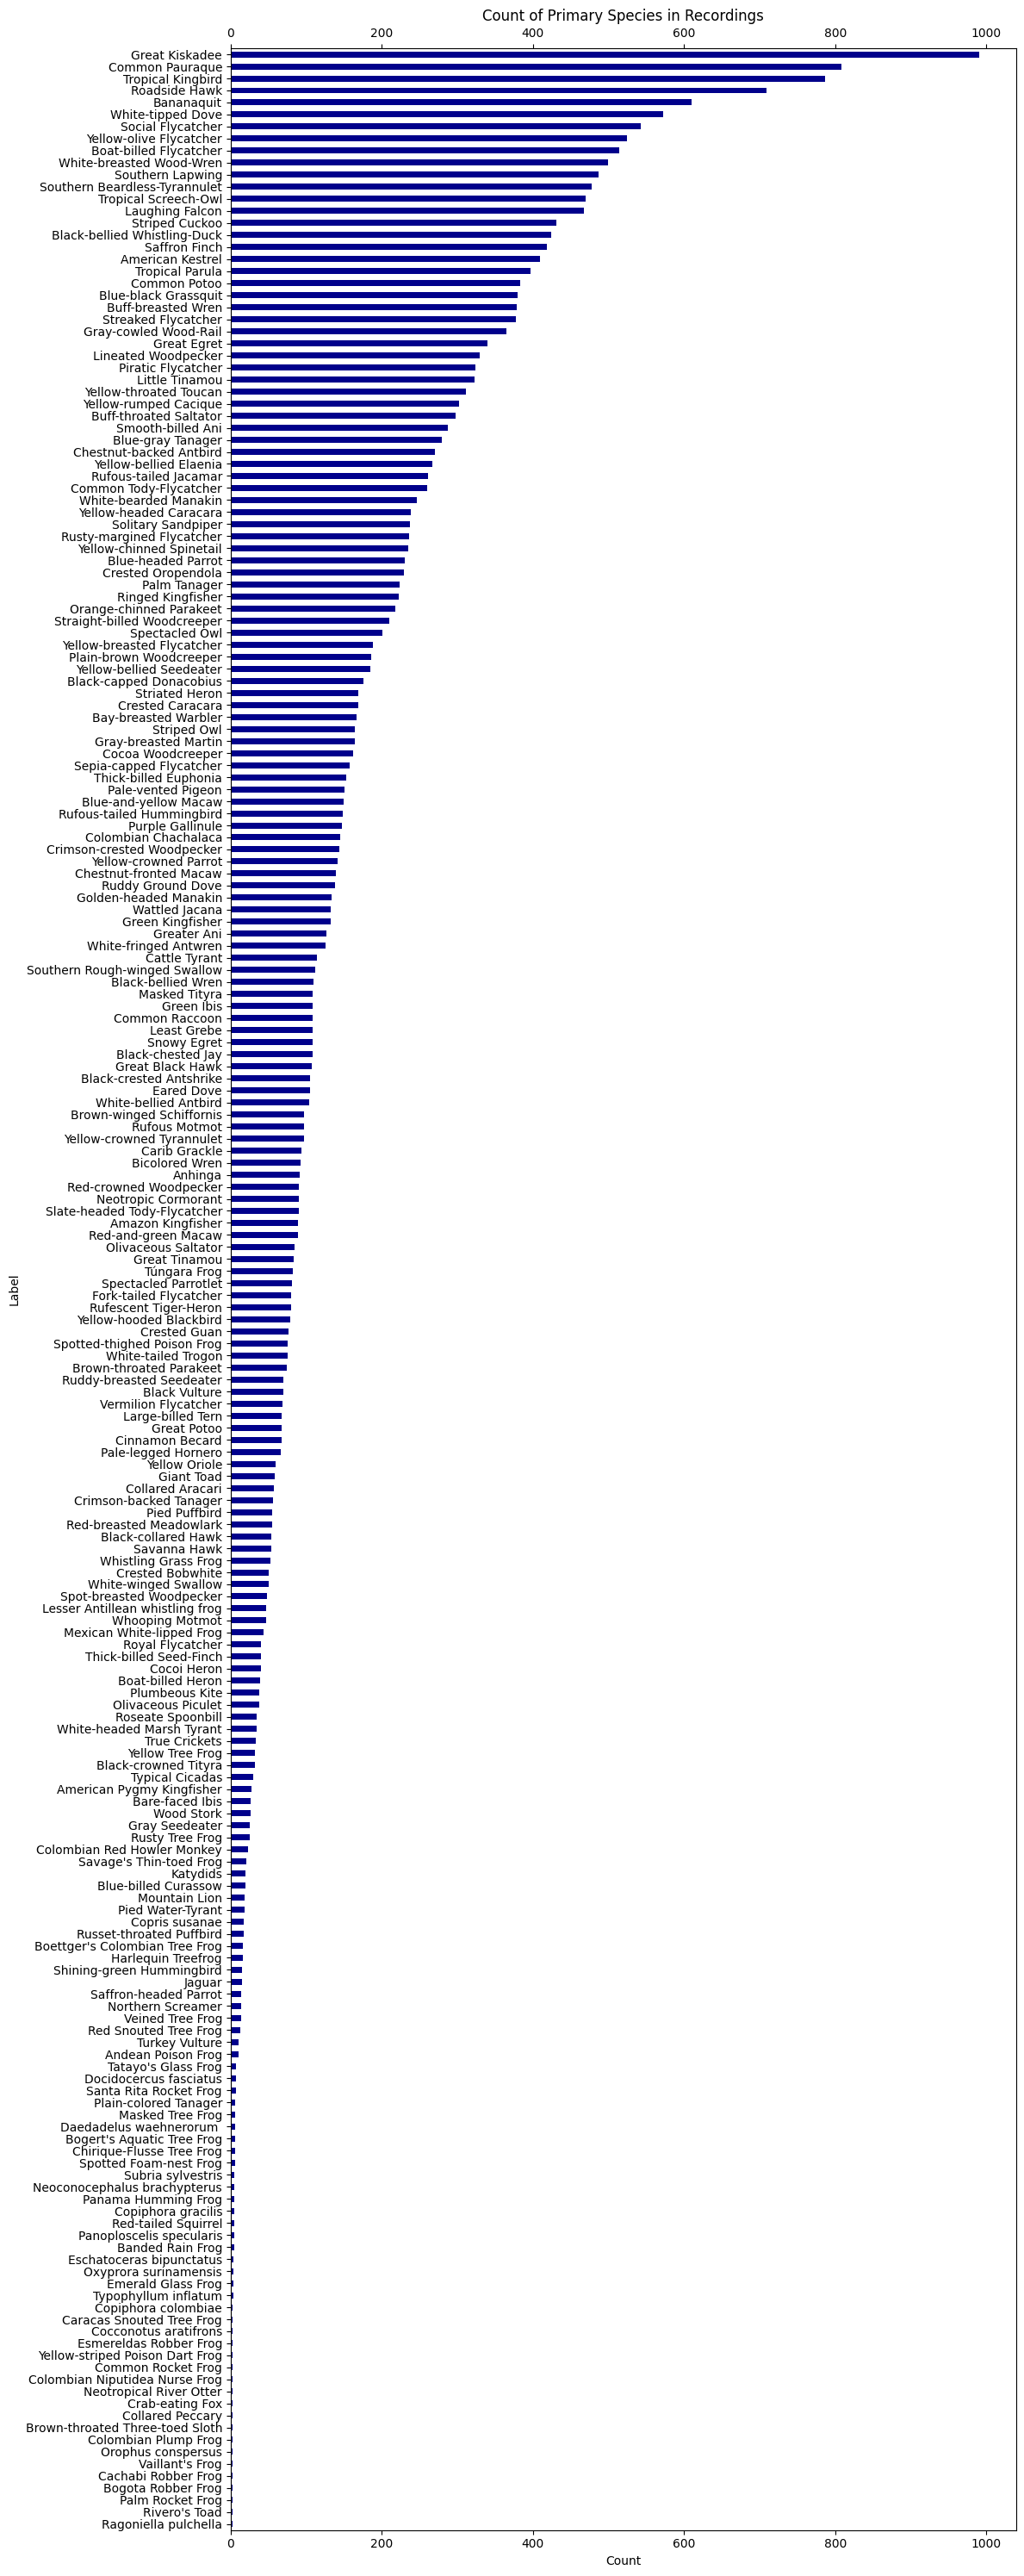

In [12]:
# Distribution of bird species in the training data

count = train_df['common_name'].value_counts(ascending=True)
plt.figure(figsize=(12, 30))
count.plot(kind='barh', color='darkblue')

plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Count of Primary Species in Recordings')
plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labeltop=True)

plt.tight_layout()
plt.show()

The distribution is highly imbalanced with a few species dominating the counts. - This imbalance may require special handling during modeling to account for rare classes, especially considering Macro ROC-AUC metric which weights all classes equally.

In [13]:
# unique primary classes
primary_labels_set = set(train_df['primary_label'].unique())


print(len(primary_labels_set))
print(primary_labels_set)

206
{'plbwoo1', '555142', '476537', 'tropar', '1462737', '1192948', 'yebsee1', 'sahpar1', 'compau', 'blctit1', '1194042', 'crebob1', 'rinkin1', '1564122', 'trokin', 'pirfly1', 'plctan1', 'blhpar1', '66893', 'chbant1', 'grasal4', 'compot1', 'royfly1', '65373', 'grekis', 'rugdov', 'whttro1', '66016', '126247', 'rufmot1', 'colcha1', 'blbgra1', 'blkvul', 'whwswa1', 'creoro1', 'ruther1', 'blcjay1', 'labter1', 'yebela1', 'shghum1', 'fotfly', 'babwar', 'strcuc1', 'chfmac1', 'grepot1', 'piepuf1', '566513', '65336', 'ragmac1', 'sobtyr1', '65419', 'spepar1', 'brtpar1', '476538', 'spbwoo1', 'paltan1', 'watjac1', '81930', '963335', '1139490', 'greani1', 'banana', 'bicwre1', 'rtlhum', 'orcpar', '523060', 'colara1', '42007', '517119', 'gretin1', 'thbeup1', '41663', 'ampkin1', 'crbtan1', 'gycwor1', 'rubsee1', 'bkcdon', '134933', '548639', '24322', 'smbani', 'speowl1', 'rumfly1', 'verfly', 'whbman1', 'baymac', 'cargra1', 'strowl1', 'palhor2', 'woosto', 'yehcar1', 'strher', '65547', 'whfant1', 'y00678'

In [14]:
# other entities combinations - might be incomplete
train_df['secondary_labels'].nunique()

745

In [15]:
# unique secondary labels
unique_secondary_labels = set()
    
for row in train_df['secondary_labels']:
    labels = ast.literal_eval(row)  # Convert string to list
    unique_secondary_labels.update(labels)  # Add to set to ensure uniqueness

print(len(unique_secondary_labels))
print(unique_secondary_labels)

133
{'', 'plbwoo1', 'tropar', 'yebsee1', 'compau', 'rinkin1', 'crebob1', 'trokin', 'pirfly1', 'plctan1', 'blhpar1', 'chbant1', 'grasal4', 'compot1', 'grekis', 'rugdov', 'whttro1', 'rufmot1', 'colcha1', 'blbgra1', 'blkvul', 'whwswa1', 'creoro1', 'ruther1', 'blcjay1', 'labter1', 'yebela1', 'fotfly', 'strcuc1', 'chfmac1', 'grepot1', 'piepuf1', '566513', 'watjac1', 'ragmac1', 'sobtyr1', 'spepar1', 'brtpar1', '476538', 'spbwoo1', 'paltan1', 'greani1', 'banana', 'bicwre1', 'rtlhum', 'orcpar', 'colara1', 'gretin1', 'thbeup1', 'crbtan1', 'gycwor1', 'rubsee1', 'bkcdon', 'smbani', 'speowl1', 'rumfly1', 'whbman1', 'baymac', 'cargra1', 'strowl1', 'palhor2', 'woosto', 'yehcar1', 'whfant1', '65547', 'strher', 'yehbla2', 'laufal1', 'y00678', 'greegr', 'snoegr', 'bbwduc', 'recwoo1', 'yeofly1', 'bubwre1', 'bafibi1', 'solsan', 'linwoo1', 'cocwoo1', 'rebbla1', 'stbwoo2', 'crcwoo1', 'yelori1', 'ywcpar', 'wbwwre1', 'amakin1', 'anhing', 'olipic1', 'purgal2', 'saffin', 'trsowl', 'whtdov', 'soulap1', 'cattyr'

In [16]:
# wether all secondary labels are present in primary labels - all present
missing_in_primary_labels = unique_secondary_labels - primary_labels_set
print(len(missing_in_primary_labels))
print(missing_in_primary_labels)

1
{''}


In [17]:
# wether all primary labels present in secondary labels - 74 missing
missing_in_secondary_labels = primary_labels_set - unique_secondary_labels   
print(len(missing_in_secondary_labels))
print(missing_in_secondary_labels)

74
{'22973', '50186', '555142', '476537', '1462737', '65344', '1192948', '81930', 'shtfly1', 'sahpar1', '65349', '963335', '46010', '1139490', '64862', 'blctit1', '66578', '1194042', '42087', '1564122', '21211', '523060', '52884', 'grbhaw1', '42007', 'blchaw1', '517119', '787625', '66893', '48124', 'royfly1', '41970', '65373', '41663', 'amekes', 'thlsch3', 'turvul', '66016', 'ampkin1', 'norscr1', '67252', 'grysee1', '126247', '134933', '528041', '715170', '548639', '24272', '24322', '21116', '67082', 'verfly', 'savhaw1', '22333', '21038', '714022', '66531', 'tbsfin1', '1462711', 'plukit1', 'bubcur1', 'shghum1', '1346504', '24292', '41778', 'babwar', '42113', '135045', '47067', '555086', '868458', '65962', '65336', '65419'}


In [18]:
# only 7.28% are present only as primary labels 
only_as_primary = train_df[train_df['primary_label'].isin(missing_in_secondary_labels)]

only_as_primary_count = only_as_primary.shape[0]
print(f"Affected samples: {only_as_primary_count}")
print(f"Affected percentage: {round((only_as_primary_count/train_df.shape[0])*100, 2)}%")

Affected samples: 2079
Affected percentage: 7.28%


In [19]:
# detected secondary entities by occurence - top k
train_df['secondary_labels'].value_counts()[:20]

secondary_labels
['']           25885
['grekis']       254
['whtdov']       165
['trokin']        83
['banana']        63
['soulap1']       59
['saffin']        58
['rugdov']        51
['yercac1']       44
['pirfly1']       42
['blbgra1']       37
['bugtan']        35
['compau']        35
['socfly1']       35
['bubwre1']       35
['cotfly1']       33
['chbant1']       32
['tropar']        30
['yebela1']       30
['rutjac1']       29
Name: count, dtype: int64

A high frequency of empty entries suggests secondary labels might be under-reported or inconsistently provided.

In [20]:
# combinations of detected secondary entities by occurence - top k
train_df[['primary_label', 'secondary_labels']].value_counts()[:20]

primary_label  secondary_labels
grekis         ['']                923
compau         ['']                787
trokin         ['']                723
roahaw         ['']                647
banana         ['']                552
whtdov         ['']                514
socfly1        ['']                478
wbwwre1        ['']                478
yeofly1        ['']                471
soulap1        ['']                459
bobfly1        ['']                459
trsowl         ['']                445
laufal1        ['']                430
sobtyr1        ['']                420
amekes         ['']                408
bbwduc         ['']                398
saffin         ['']                382
strcuc1        ['']                381
tropar         ['']                368
compot1        ['']                367
Name: count, dtype: int64

In [21]:
# Convert secondary_labels from string to list
train_df_cp = train_df.copy()

train_df_cp['secondary_labels'] = train_df['secondary_labels'].apply(ast.literal_eval)

# Remove empty strings from lists
train_df_cp['secondary_labels'] = train_df_cp['secondary_labels'].apply(lambda x: [lbl for lbl in x if lbl.strip()])

# Filter out rows where secondary_labels is still empty after cleaning
filtered_df = train_df_cp[train_df_cp['secondary_labels'].apply(lambda x: len(x) > 0)]

# Convert lists to tuples for proper counting
filtered_df['secondary_labels'] = filtered_df['secondary_labels'].apply(tuple)

# Get value counts
primary_secondary_stats = filtered_df.value_counts(subset=['primary_label', 'secondary_labels'])

<ipython-input-21-e8a0aead5166>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['secondary_labels'] = filtered_df['secondary_labels'].apply(tuple)


In [22]:
# no strong pairs found
primary_secondary_stats[:20]

primary_label  secondary_labels
trokin         (grekis,)           13
saffin         (grekis,)            9
socfly1        (grekis,)            9
compot1        (compau,)            9
yercac1        (grekis,)            8
yecspi2        (grekis,)            8
bubwre1        (whtdov,)            7
tropar         (whtdov,)            7
strcuc1        (grekis,)            7
bobfly1        (grekis,)            7
               (whtdov,)            6
sobtyr1        (grekis,)            6
rutjac1        (whtdov,)            6
grekis         (trokin,)            6
blbgra1        (trokin,)            6
               (whtdov,)            6
grekis         (socfly1,)           6
yeofly1        (secfly1,)           6
greibi1        (grekis,)            6
yeofly1        (whtdov,)            6
Name: count, dtype: int64

## Type analysis

In [23]:
unique_types = set()
    
for row in train_df['type'].copy():
    labels = ast.literal_eval(row)  #  string to list
    unique_types.update(labels)  

print(len(unique_types))
# print(unique_types)

587


In [24]:
 train_df['type'].value_counts()[: 30]

type
['song']                           9437
['']                               8099
['call']                           5746
['call', 'song']                   1088
['flight call']                     804
['alarm call']                      346
['call', 'calls']                   178
['dawn song']                       170
['uncertain']                       168
['call', 'flight call']             163
['flight call', 'song']             117
['drumming']                        104
['duet']                             98
['alarm call', 'call']               94
['duet', 'song']                     91
['canto']                            73
['begging call']                     68
['flight call', 'flight calls']      55
['alarm call', 'flight call']        55
['nocturnal flight call']            48
['subsong']                          44
['begging call', 'call']             36
['alarm call', 'song']               35
['call', 'duet', 'song']             33
['call', 'duet']                   

The dataset predominantly consists of one recording type, which simplifies analysis but may limit the diversity of sound events.

In [25]:
# type + primary labels relationships 
train_df[['primary_label' ,'type']].value_counts()[: 30]

primary_label  type    
grekis         ['']        503
compau         ['']        394
trokin         ['']        348
whtdov         ['song']    320
banana         ['song']    313
wbwwre1        ['song']    295
amekes         ['']        279
compau         ['song']    270
yeofly1        ['song']    248
tropar         ['song']    244
compot1        ['']        229
blbgra1        ['song']    228
soulap1        ['']        227
roahaw         ['call']    225
littin1        ['song']    224
roahaw         ['']        219
bbwduc         ['']        208
trsowl         ['song']    206
grekis         ['call']    203
whtdov         ['']        201
trsowl         ['']        190
laufal1        ['']        190
banana         ['']        189
trokin         ['song']    189
socfly1        ['']        189
butsal1        ['song']    188
saffin         ['']        188
strcuc1        ['song']    185
bobfly1        ['']        174
bubwre1        ['song']    170
Name: count, dtype: int64

In [26]:
### type + primary labels relationships where type is not empty 


# Function to parse 'type' column correctly
def parse_type(type_str):
    labels = type_str.strip("[]").replace("'", "").split(", ")
    return [lbl for lbl in labels if lbl]  # Remove empty labels

# Parse 'type' column
train_df_cp = train_df.copy()
train_df_cp['type'] = train_df['type'].apply(parse_type)

# Filter out rows where 'type' is empty
filtered_df = train_df_cp[train_df_cp['type'].apply(lambda x: len(x) > 0)]

# Convert lists to tuples for proper counting
filtered_df['type'] = filtered_df['type'].apply(tuple)

# Get value counts for (primary_label, type), showing top 30
primary_type_stats = filtered_df.value_counts(subset=['primary_label', 'type'])

<ipython-input-26-053f6569cfed>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['type'] = filtered_df['type'].apply(tuple)


In [27]:
primary_type_stats[:30]

primary_label  type   
whtdov         (song,)    320
banana         (song,)    313
wbwwre1        (song,)    295
compau         (song,)    270
yeofly1        (song,)    248
tropar         (song,)    244
blbgra1        (song,)    228
roahaw         (call,)    225
littin1        (song,)    224
trsowl         (song,)    206
grekis         (call,)    203
trokin         (song,)    189
butsal1        (song,)    188
strcuc1        (song,)    185
bubwre1        (song,)    170
socfly1        (call,)    170
roahaw         (song,)    168
saffin         (song,)    164
pirfly1        (song,)    164
sobtyr1        (song,)    162
grekis         (song,)    160
stbwoo2        (song,)    158
strfly1        (call,)    149
yeofly1        (call,)    146
yebsee1        (song,)    140
trokin         (call,)    139
laufal1        (song,)    139
chbant1        (song,)    136
compot1        (song,)    132
bobfly1        (call,)    131
Name: count, dtype: int64

## Collection Analysis

In [28]:
train_df.collection.value_counts()

collection
XC      21204
iNat     7198
CSA       162
Name: count, dtype: int64

https://www.kaggle.com/competitions/birdclef-2025/discussion/568886

Here is a discussion - about human voice in CSA collection.

Some insights:

After a short analysis, it was clear, that almost all CSA recordings contain human voice.

This could be easy to exclude human voice, but the recordings by other authors have different patterns. For example, Alexandra Buitrago-Cardona says something at the beginning of the recordings (and, sometimes, at the end or in the middle).

In [29]:
# how many distinct classes are captured by each collection

distinct_classes_per_collection = train_df.groupby("collection")["primary_label"].nunique()
print(distinct_classes_per_collection)

collection
CSA      20
XC      171
iNat    176
Name: primary_label, dtype: int64


In [30]:
primary_label_distribution = train_df.groupby("collection")["primary_label"].value_counts()

In [31]:
# top k classes from iNat
primary_label_distribution['iNat'][:20]

primary_label
grekis     491
compau     380
trokin     327
amekes     277
soulap1    216
compot1    211
roahaw     209
bbwduc     204
whtdov     191
socfly1    187
laufal1    183
trsowl     183
saffin     182
bobfly1    169
banana     156
strcuc1    147
gycwor1    137
bkmtou1    118
41663      105
tropar     105
Name: count, dtype: int64

In [32]:
# top k classes from XC
primary_label_distribution['XC'][:20]

primary_label
roahaw     500
grekis     499
yeofly1    466
trokin     460
banana     454
wbwwre1    442
compau     428
whtdov     381
sobtyr1    374
socfly1    356
bubwre1    354
bobfly1    345
greegr     299
blbgra1    296
strfly1    294
tropar     292
trsowl     287
pirfly1    285
yercac1    285
laufal1    284
Name: count, dtype: int64

In [33]:
# top k classes from CSA
primary_label_distribution['CSA'][:20]

primary_label
52884      33
50186      30
48124      20
715170     17
1462737     7
1564122     6
1346504     5
548639      5
714022      5
963335      5
1192948     4
523060      4
868458      4
1194042     3
1462711     3
24292       3
1139490     2
476537      2
528041      2
64862       2
Name: count, dtype: int64

In [34]:
# how each primary_label is split across XC, iNat, and CSA.

pivot_table = train_df.pivot_table(index="primary_label", columns="collection", aggfunc="size", fill_value=0)
print(pivot_table)

collection     CSA   XC  iNat
primary_label                
1139490          2    0     0
1192948          4    0     0
1194042          3    0     0
126247           0    1     5
1346504          5    0     0
...            ...  ...   ...
yehcar1          0  192    46
yelori1          0   51     9
yeofly1          0  466    59
yercac1          0  285    17
ywcpar           0  117    25

[206 rows x 3 columns]


In [35]:
# top k classes by collections

K = 30  # Set your desired top K
top_k_labels = train_df["primary_label"].value_counts().head(K).index
print(top_k_labels)
print()
filtered_df = train_df[train_df["primary_label"].isin(top_k_labels)]
pivot_table_top_k = filtered_df.pivot_table(index="primary_label", columns="collection", aggfunc="size", fill_value=0)
print(pivot_table_top_k)

Index(['grekis', 'compau', 'trokin', 'roahaw', 'banana', 'whtdov', 'socfly1',
       'yeofly1', 'bobfly1', 'wbwwre1', 'soulap1', 'sobtyr1', 'trsowl',
       'laufal1', 'strcuc1', 'bbwduc', 'saffin', 'amekes', 'tropar', 'compot1',
       'blbgra1', 'bubwre1', 'strfly1', 'gycwor1', 'greegr', 'linwoo1',
       'pirfly1', 'littin1', 'bkmtou1', 'yercac1'],
      dtype='object', name='primary_label')

collection      XC  iNat
primary_label           
amekes         132   277
banana         454   156
bbwduc         220   204
bkmtou1        193   118
blbgra1        296    84
bobfly1        345   169
bubwre1        354    25
compau         428   380
compot1        172   211
greegr         299    41
grekis         499   491
gycwor1        228   137
laufal1        284   183
linwoo1        277    53
littin1        280    43
pirfly1        285    39
roahaw         500   209
saffin         237   182
sobtyr1        374   104
socfly1        356   187
soulap1        271   216
strcuc1        284   147
s

In [36]:
# Define epsilon range
epsilon = 0.05

# Calculate dataset-wide collection distribution
collection_totals = train_df["collection"].value_counts(normalize=True)
xc_ratio = collection_totals["iNat"] / collection_totals["XC"]

lower_bound = xc_ratio - epsilon
upper_bound = xc_ratio + epsilon

print("Collections balance ratio:", round(xc_ratio, 2))
print("Lower bound:", round(lower_bound, 2))
print("Upper bound:", round(upper_bound, 2))
print()

# Get the top K primary labels
K = 20  # Change this to desired top K
top_k_labels = train_df["primary_label"].value_counts().head(K).index

# Filter dataframe
filtered_df = train_df[train_df["primary_label"].isin(top_k_labels)]
pivot_table_top_k = filtered_df.pivot_table(index="primary_label", columns="collection", aggfunc="size", fill_value=0)

# Compute iNat/XC ratio safely
pivot_table_top_k["iNat_XC_ratio"] = np.where(
    pivot_table_top_k["XC"] > 0, 
    pivot_table_top_k["iNat"] / pivot_table_top_k["XC"], 
    np.nan  # Avoid division by zero
)
pivot_table_top_k["iNat_XC_ratio"].fillna(0, inplace=True)  

# Determine whether the class is within expected range
pivot_table_top_k["within_expected_range"] = pivot_table_top_k["iNat_XC_ratio"].between(lower_bound, upper_bound)

# Determine bias direction
pivot_table_top_k["bias_towards"] = np.select(
    [
        pivot_table_top_k["iNat_XC_ratio"] < lower_bound,  # Less iNat, more XC
        pivot_table_top_k["iNat_XC_ratio"] > upper_bound   # More iNat, less XC
    ],
    ["XC", "iNat"],
    default="Neutral"  # Within expected range
)

print(pivot_table_top_k)

Collections balance ratio: 0.34
Lower bound: 0.29
Upper bound: 0.39

collection      XC  iNat  iNat_XC_ratio  within_expected_range bias_towards
primary_label                                                              
amekes         132   277       2.098485                  False         iNat
banana         454   156       0.343612                   True      Neutral
bbwduc         220   204       0.927273                  False         iNat
bobfly1        345   169       0.489855                  False         iNat
compau         428   380       0.887850                  False         iNat
compot1        172   211       1.226744                  False         iNat
grekis         499   491       0.983968                  False         iNat
laufal1        284   183       0.644366                  False         iNat
roahaw         500   209       0.418000                  False         iNat
saffin         237   182       0.767932                  False         iNat
sobtyr1        374 

<ipython-input-36-f30a3cf29eb8>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pivot_table_top_k["iNat_XC_ratio"].fillna(0, inplace=True)


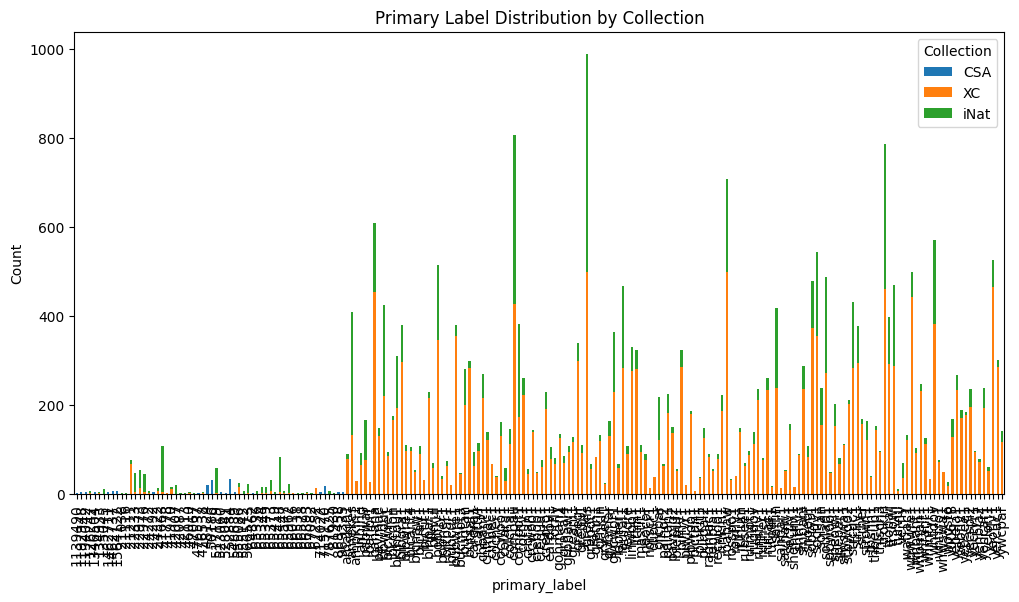

In [37]:
# primary label distribution by collection

pivot_table.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.ylabel("Count")
plt.title("Primary Label Distribution by Collection")
plt.legend(title="Collection")
plt.show()

This graph shows that XC dominates in general but for some high frequency classes iNat contributes almost equally, which implies a little bias considering iNat collections is much less than XC in train dataset.

What is going on with low frequency classes?

In [38]:
# top k inversed classes by collections 

K = 20  # Set your desired top K
top_k_labels = train_df["primary_label"].value_counts().tail(K).index
print(top_k_labels)
print()
filtered_df = train_df[train_df["primary_label"].isin(top_k_labels)]
pivot_table_top_k = filtered_df.pivot_table(index="primary_label", columns="collection", aggfunc="size", fill_value=0)
print(pivot_table_top_k)

Index(['523060', '24292', '65419', '1194042', '1462711', '81930', '67082',
       '66578', '66531', '66016', '21038', '41778', '21116', '64862', '528041',
       '476537', '47067', '42113', '42087', '1139490'],
      dtype='object', name='primary_label')

collection     CSA  XC  iNat
primary_label               
1139490          2   0     0
1194042          3   0     0
1462711          3   0     0
21038            0   0     2
21116            0   0     2
24292            3   0     0
41778            0   1     1
42087            0   0     2
42113            0   0     2
47067            0   0     2
476537           2   0     0
523060           4   0     0
528041           2   0     0
64862            2   0     0
65419            0   0     3
66016            0   1     1
66531            0   0     2
66578            0   0     2
67082            0   0     2
81930            0   0     2


iNat also dominates in low frequency classes compared to XC, whereas XC has most entries lying somewhere in the middle by frequency rate.

## Author Analysis

In [39]:
train_df.author.value_counts()

author
JAYRSON ARAUJO DE OLIVEIRA    1780
Unknown                       1612
Bernabe Lopez-Lanus            768
Jerome Fischer                 743
Dante Buzzetti                 562
                              ... 
Rita Flores Wiskowski            1
Guy Babineau                     1
Millie Basden                    1
Gonzalo Roget                    1
Nerieth Leuro                    1
Name: count, Length: 2493, dtype: int64

In [40]:
train_df.author.value_counts().describe()

count    2493.000000
mean       11.457682
std        63.281350
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1780.000000
Name: count, dtype: float64

In [41]:
# top primary classes by top authors by frequency
k = 5

# Get the top k authors by frequency
top_authors = train_df.author.value_counts().head(k).index

# Filter the DataFrame for these authors only
top_authors_df = train_df[train_df.author.isin(top_authors)]

# Group by author and primary_label, then count frequencies
author_primary_counts = top_authors_df.groupby(['author', 'primary_label']).size().reset_index(name='frequency')

# Sort the results so that the most frequent primary label per author appears first
author_primary_sorted = author_primary_counts.sort_values(['author', 'frequency'], ascending=[True, False])

# To see just the top primary label for each author:
top_primaries = 5
top_primary_per_author = author_primary_sorted.groupby('author').head(top_primaries)


In [42]:
top_primary_per_author

author primary_label  frequency
62          Bernabe Lopez-Lanus        roahaw         28
75          Bernabe Lopez-Lanus       socfly1         27
103         Bernabe Lopez-Lanus       yehbla2         21
88          Bernabe Lopez-Lanus        tropar         19
106         Bernabe Lopez-Lanus       yeofly1         19
209              Dante Buzzetti       yecspi2         62
125              Dante Buzzetti       bubwre1         18
213              Dante Buzzetti       yeofly1         18
194              Dante Buzzetti       thlsch3         12
132              Dante Buzzetti        compau         11
321  JAYRSON ARAUJO DE OLIVEIRA       yeofly1         60
221  JAYRSON ARAUJO DE OLIVEIRA        banana         48
282  JAYRSON ARAUJO DE OLIVEIRA       rutjac1         39
237  JAYRSON ARAUJO DE OLIVEIRA       butsal1         38
315  JAYRSON ARAUJO DE OLIVEIRA       yebela1         37
441              Jerome Fischer       yeofly1         23
427              Jerome Fischer       wbwwre1         22
408              Jerome Fischer       sobtyr1         21
421              Jerome Fischer       thbeup1         20
423              Jerome Fischer        trokin         19
499                     Unknown       compot1        137
510                     Unknown        grekis        114
498                     Unknown        compau         82
474                     Unknown        bbwduc         63
469                     Unknown        amekes         56

In [43]:
# authors distribution for top k most frequent classes

k = 10

# top k primary labels by frequency
top_labels = train_df['primary_label'].value_counts().head(k).index

# these top labels df
top_labels_df = train_df[train_df['primary_label'].isin(top_labels)]

# group by primary_label and get unique authors for each label
authors_by_label = top_labels_df.groupby('primary_label')['author'].unique().reset_index()

# If you prefer a flattened structure (one row per primary label - author pair)
authors_by_label_exploded = authors_by_label.explode('author')

print("Top primary labels with their respective authors (grouped):")
print(authors_by_label)

print("\nFlattened view (each row is a primary label and an author):")
print(authors_by_label_exploded)

Top primary labels with their respective authors (grouped):
  primary_label                                             author
0        banana  [Adrian Eisen Rupp, Noé Eiterer, Oswaldo Corte...
1       bobfly1  [Fabricio Gorleri, Noé Eiterer, GABRIEL LEITE,...
2        compau  [Chris Harrison, Paulo Affonso Fonseca Pires N...
3        grekis  [Sander Bot, Noé Eiterer, Andrew Spencer, Lars...
4        roahaw  [Sander Bot, Noé Eiterer, Raul_Rene, Oswaldo C...
5       socfly1  [Allen T. Chartier, Noé Eiterer, GABRIEL LEITE...
6        trokin  [Noé Eiterer, GABRIEL LEITE, Lars Lachmann, Ri...
7       wbwwre1  [Allen T. Chartier, Sander Bot, William Adsett...
8        whtdov  [Niels Krabbe, Sander Bot, Noé Eiterer, Eric D...
9       yeofly1  [Jon King, Noé Eiterer, Oswaldo Cortes, GABRIE...

Flattened view (each row is a primary label and an author):
   primary_label                     author
0         banana          Adrian Eisen Rupp
0         banana                Noé Eiterer
0         

## Taxonomy Classes Analysis

In [44]:
train_df.class_name.value_counts()

class_name
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64

In [45]:
# primary classes distribution by taxonomy classes

taxonomy_distribution = train_df.groupby("class_name")["primary_label"].nunique().sort_values(ascending=False)
print(taxonomy_distribution)

class_name
Aves        146
Amphibia     34
Insecta      17
Mammalia      9
Name: primary_label, dtype: int64


In [46]:
# pivot table (species as index, class names as columns)
taxonomy_pivot = train_df.pivot_table(index="primary_label", 
                                      columns="class_name", 
                                      aggfunc="size", 
                                      fill_value=0)

# counts across all classes for each species
taxonomy_pivot['Total_Frequency'] = taxonomy_pivot.sum(axis=1)

# pivot table by the total frequency in descending order
sorted_taxonomy = taxonomy_pivot.sort_values(by='Total_Frequency', ascending=False)

In [47]:
# top 10 species by frequency
print(sorted_taxonomy.head(10))

class_name     Amphibia  Aves  Insecta  Mammalia  Total_Frequency
primary_label                                                    
grekis                0   990        0         0              990
compau                0   808        0         0              808
trokin                0   787        0         0              787
roahaw                0   709        0         0              709
banana                0   610        0         0              610
whtdov                0   572        0         0              572
socfly1               0   543        0         0              543
yeofly1               0   525        0         0              525
bobfly1               0   514        0         0              514
wbwwre1               0   499        0         0              499


In [48]:
# last 10 species by frequency
print(sorted_taxonomy.tail(10))

class_name     Amphibia  Aves  Insecta  Mammalia  Total_Frequency
primary_label                                                    
21038                 2     0        0         0                2
41778                 0     0        0         2                2
21116                 2     0        0         0                2
64862                 2     0        0         0                2
528041                0     0        2         0                2
476537                2     0        0         0                2
47067                 0     0        0         2                2
42113                 0     0        0         2                2
42087                 0     0        0         2                2
1139490               0     0        2         0                2


## Rating Analysis

Values in 1..5 (1 - low quality, 5 - high quality) provided by users of Xeno-canto; 0 implies no rating is available; 

iNaturalist and the CSA do not provide quality ratings.

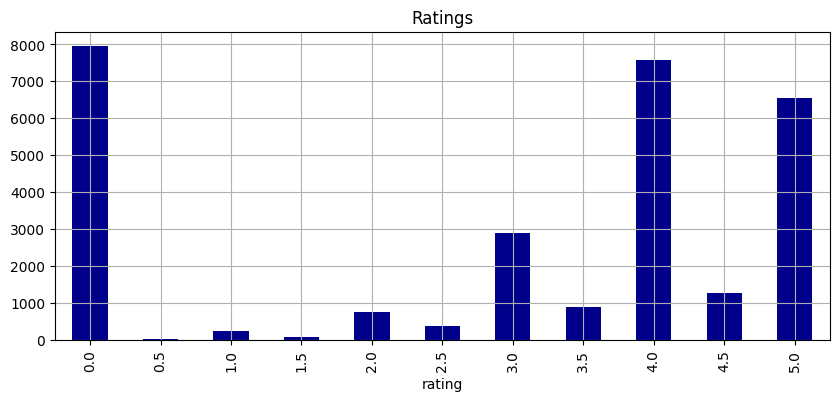

In [49]:
# quality score values distribution - 0 = no score provided

plt.figure(figsize=(10,4))
train_df.rating.value_counts().sort_index().plot(kind='bar', color='darkblue')
plt.title('Ratings')
plt.grid()
plt.show()

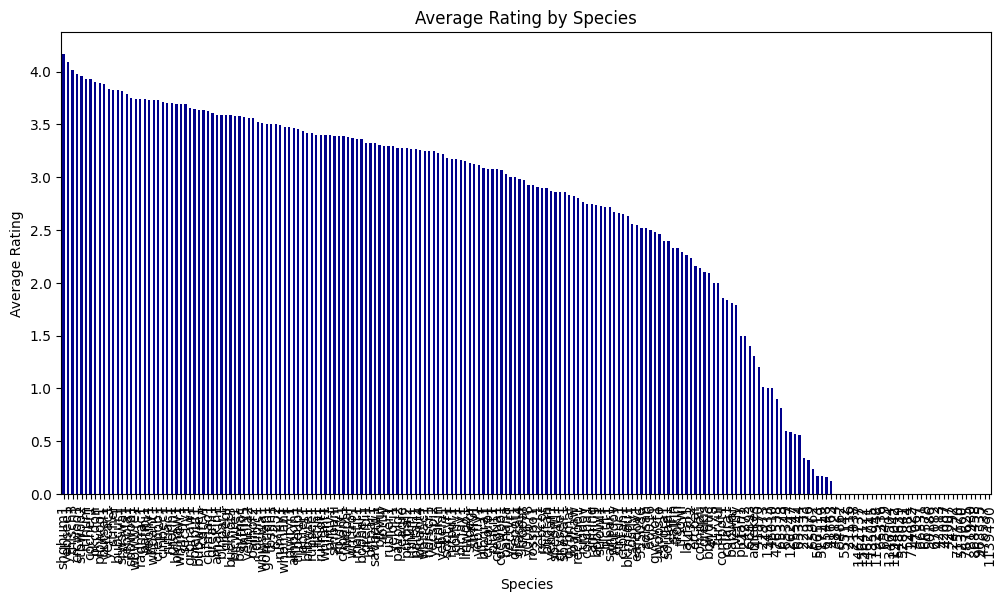

In [50]:
# Average Rating by Species - need to check for 0 and others

avg_rating_by_species = train_df.groupby('primary_label')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
avg_rating_by_species.plot(kind='bar', color='darkblue')
plt.title("Average Rating by Species")
plt.xlabel("Species")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.show()

Average ratings differ among species, indicating which species tend to have higher or lower/absent quality recordings.

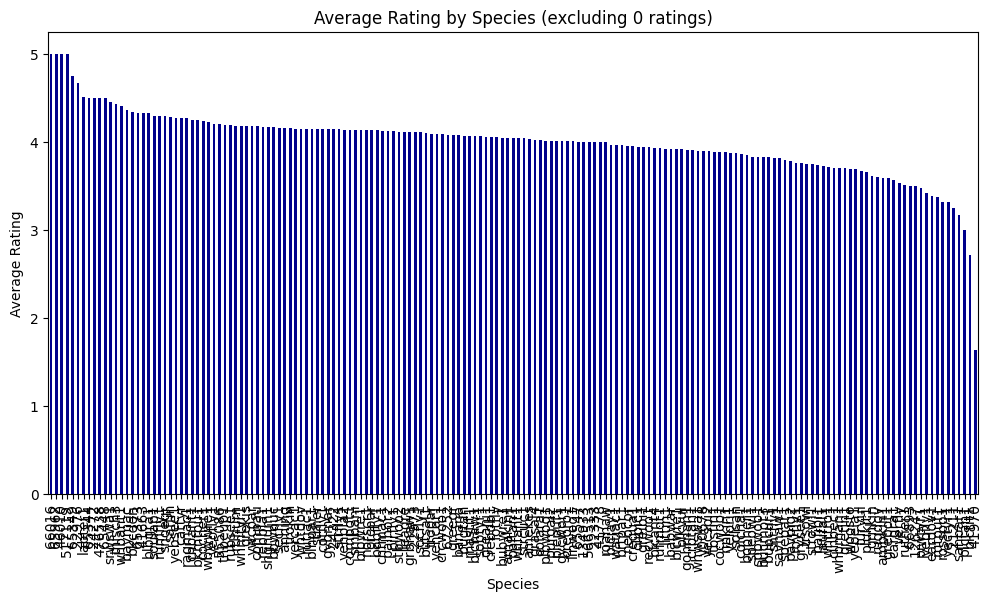

In [51]:
nonzero_ratings_df = train_df[train_df['rating'] != 0]

# Compute the average rating by species for non-zero ratings only
avg_rating_by_species = nonzero_ratings_df.groupby('primary_label')['rating'].mean().sort_values(ascending=False)

# Plot the average ratings
plt.figure(figsize=(12,6))
avg_rating_by_species.plot(kind='bar', color='darkblue')
plt.title("Average Rating by Species (excluding 0 ratings)")
plt.xlabel("Species")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.show()


In [52]:
# non-zero rating distribution
non_zero_df = train_df[train_df["rating"] > 0]
non_zero_distribution = non_zero_df["collection"].value_counts()
print(non_zero_distribution)

collection
XC    20616
Name: count, dtype: int64


All samples with provided rating come from XC collection

In [53]:
# collections distribution reminder
train_df.collection.value_counts()

collection
XC      21204
iNat     7198
CSA       162
Name: count, dtype: int64

In [54]:
# zero percentage in collection
zero_ratings = train_df[train_df["rating"] == 0]["collection"].value_counts(normalize=False)
print("Zero Rating Distribution by Collection:\n", zero_ratings)

Zero Rating Distribution by Collection:
 collection
iNat    7198
XC       588
CSA      162
Name: count, dtype: int64


iNat and CSA collections do not provide rating

## Geo Analysis

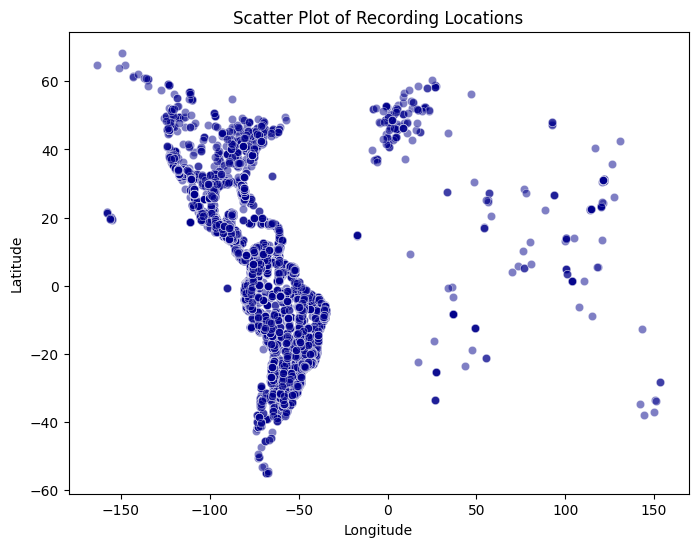

Latitude bounds: -51.98 - 46.40
Longitude bounds: -118.42 - -15.03
Number of geographical outliers: 514
Sample geographical outliers:
     latitude  longitude
297   49.1523     2.3752
312   48.7247  -122.3529
314   46.8702  -109.2880
315   47.4701  -122.6372
317   49.6044  -117.1258


In [55]:
# source - https://www.kaggle.com/code/younusmohamed/53-01-complete-eda

# Remove rows with missing coordinate values
location_data = train_df.dropna(subset=['latitude', 'longitude'])

# Scatterplot of # relationship between latitude and longitude
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', data=location_data, alpha=0.5, color = 'darkblue')
plt.title("Scatter Plot of Recording Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Calculate IQR for latitude
lat_Q1 = location_data['latitude'].quantile(0.25)
lat_Q3 = location_data['latitude'].quantile(0.75)
lat_IQR = lat_Q3 - lat_Q1
lat_lower_bound = lat_Q1 - 1.5 * lat_IQR
lat_upper_bound = lat_Q3 + 1.5 * lat_IQR

# Calculate IQR for longitude
lon_Q1 = location_data['longitude'].quantile(0.25)
lon_Q3 = location_data['longitude'].quantile(0.75)
lon_IQR = lon_Q3 - lon_Q1
lon_lower_bound = lon_Q1 - 1.5 * lon_IQR
lon_upper_bound = lon_Q3 + 1.5 * lon_IQR

print(f"Latitude bounds: {lat_lower_bound:.2f} - {lat_upper_bound:.2f}")
print(f"Longitude bounds: {lon_lower_bound:.2f} - {lon_upper_bound:.2f}")

# Identify geographical outliers
geo_outliers = location_data[
    (location_data['latitude'] < lat_lower_bound) | (location_data['latitude'] > lat_upper_bound) |
    (location_data['longitude'] < lon_lower_bound) | (location_data['longitude'] > lon_upper_bound)
]
print("Number of geographical outliers:", geo_outliers.shape[0])
print("Sample geographical outliers:")
print(geo_outliers[['latitude', 'longitude']].head())

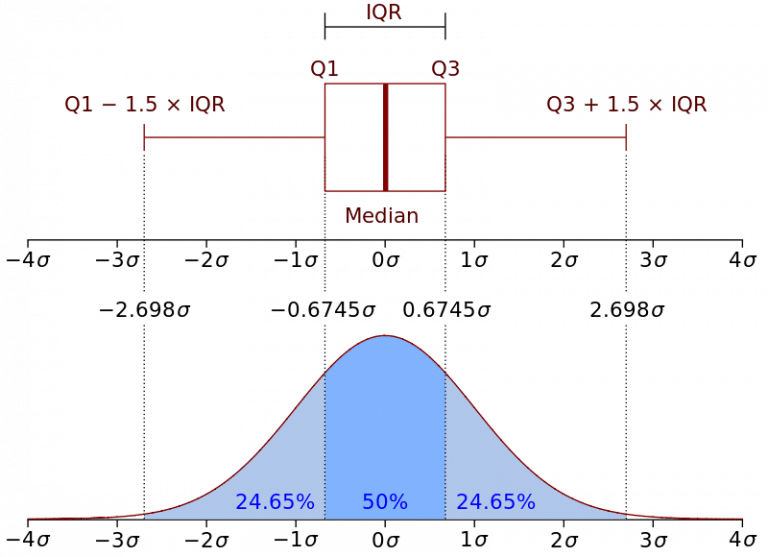
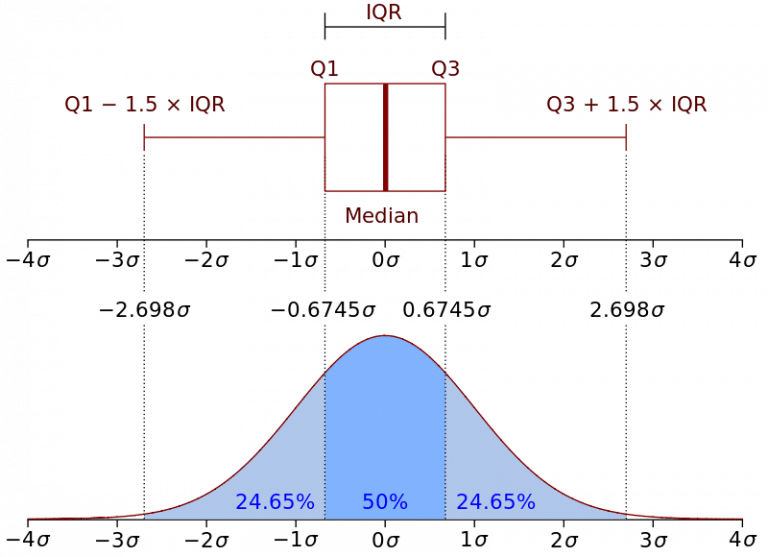

###  Geo by batches fromed by labels frequency

#### The most frequent labels

In [56]:
prim_freq = train_df.primary_label.value_counts()
prim_freq

primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
          ... 
476537       2
47067        2
42113        2
42087        2
1139490      2
Name: count, Length: 206, dtype: int64

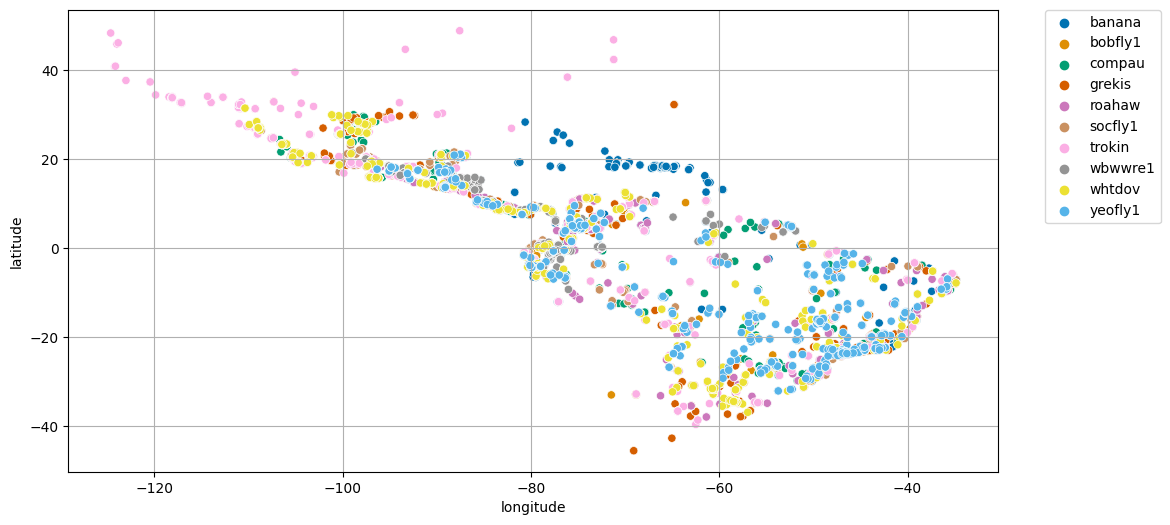

In [57]:
# source - https://www.kaggle.com/code/docxian/birdclef-2025-eda-geography#Static-plots

# select first 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(prim_freq[0:9+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # move legend out of the plot area
plt.grid()
plt.show()

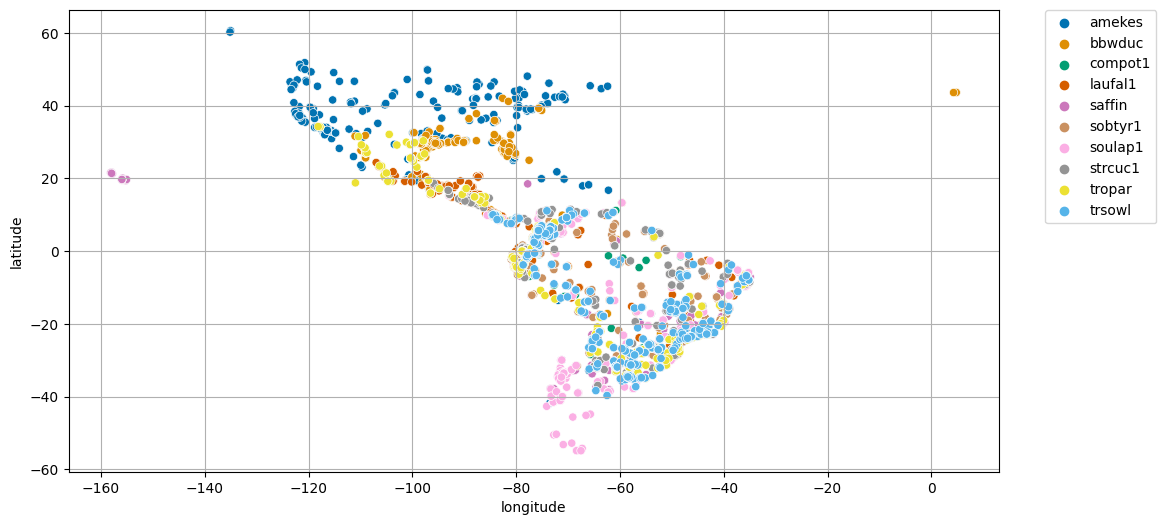

In [58]:
# select next 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(prim_freq[10:19+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

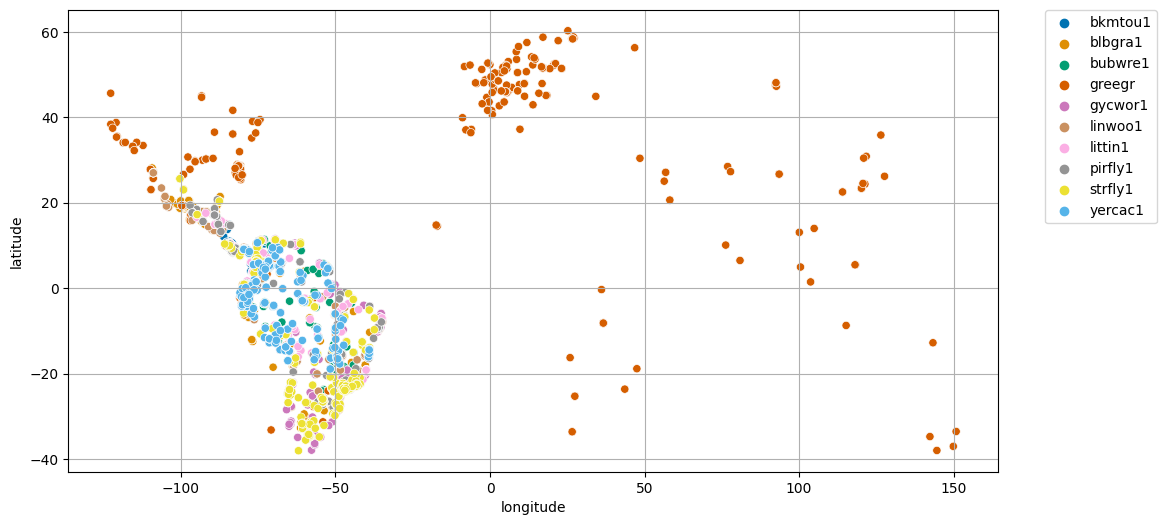

In [59]:
# select next 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(prim_freq[20:29+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

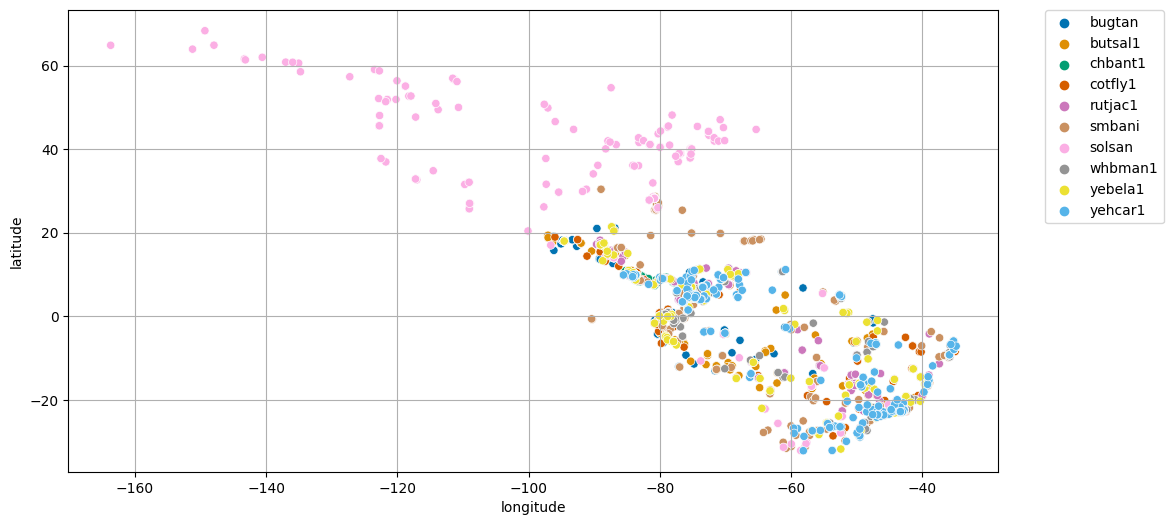

In [60]:
# select next 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(prim_freq[30:39+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

#### The least frequent labels

In [61]:
asc_prim_freq = train_df.primary_label.value_counts(ascending=True)
asc_prim_freq

primary_label
1139490      2
81930        2
67082        2
66578        2
66531        2
          ... 
banana     610
roahaw     709
trokin     787
compau     808
grekis     990
Name: count, Length: 206, dtype: int64

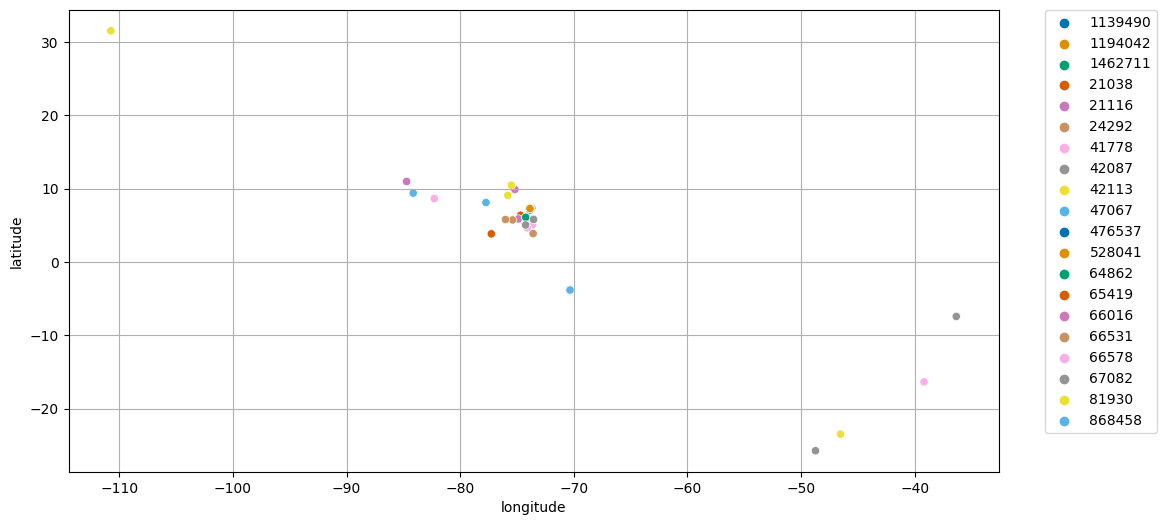

In [62]:
# select first 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(asc_prim_freq[0:19+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # move legend out of the plot area
plt.grid()
plt.show()

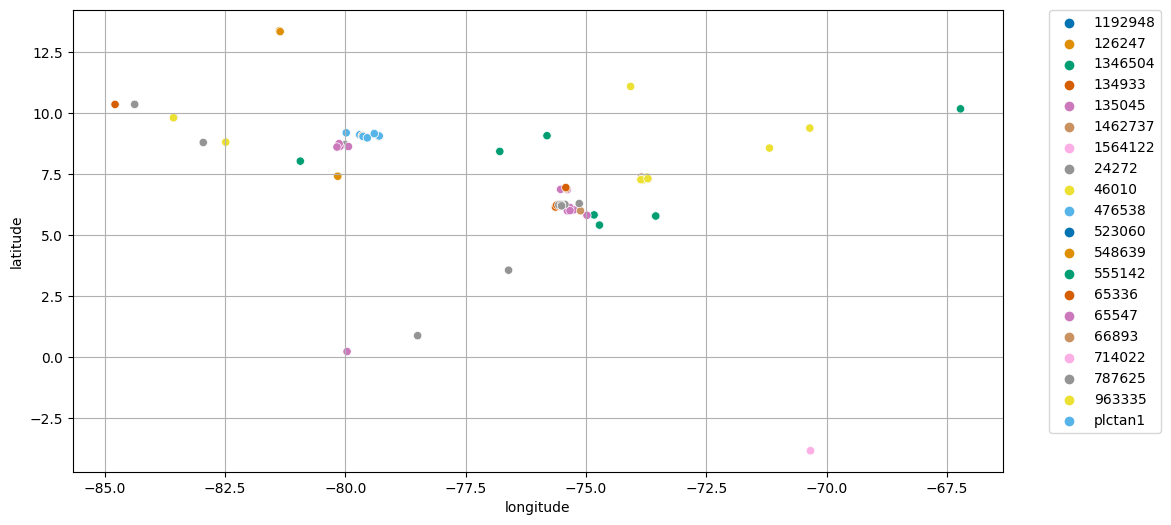

In [63]:
# select first 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(asc_prim_freq[20:39+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # move legend out of the plot area
plt.grid()
plt.show()

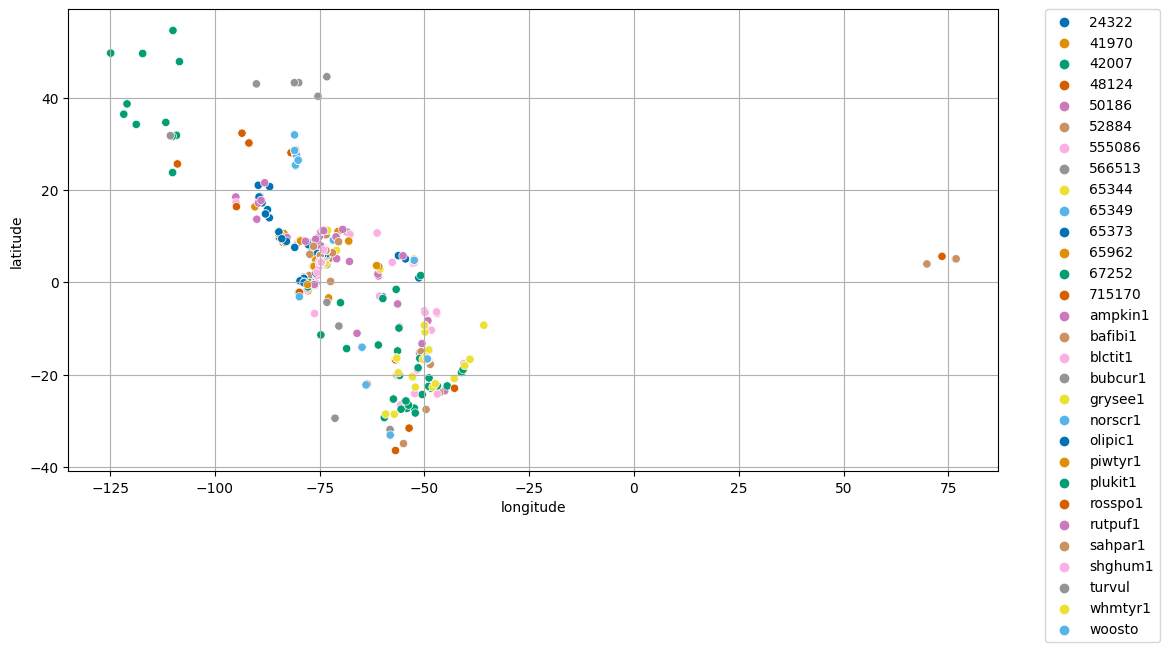

In [64]:
# select first 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(asc_prim_freq[40:69+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # move legend out of the plot area
plt.grid()
plt.show()

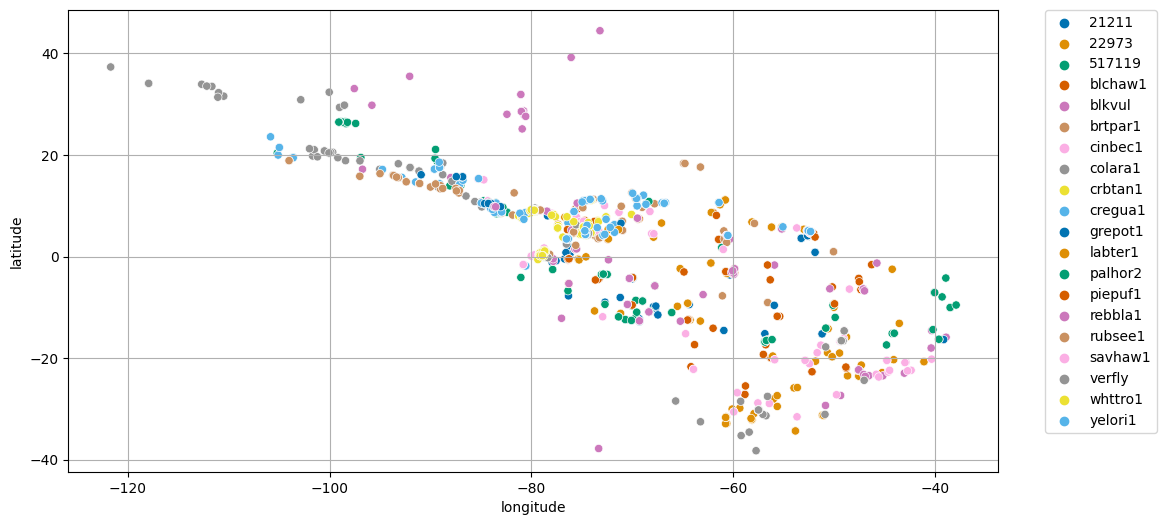

In [65]:
# select first 10 categories and plot in color
df_select = train_df[train_df.primary_label.isin(asc_prim_freq[80:99+1].index)]
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', hue='primary_label', data=df_select, palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # move legend out of the plot area
plt.grid()
plt.show()

### Geo by class names

In [66]:
classes = train_df.class_name.value_counts().index.tolist()
print(classes)

['Aves', 'Amphibia', 'Mammalia', 'Insecta']


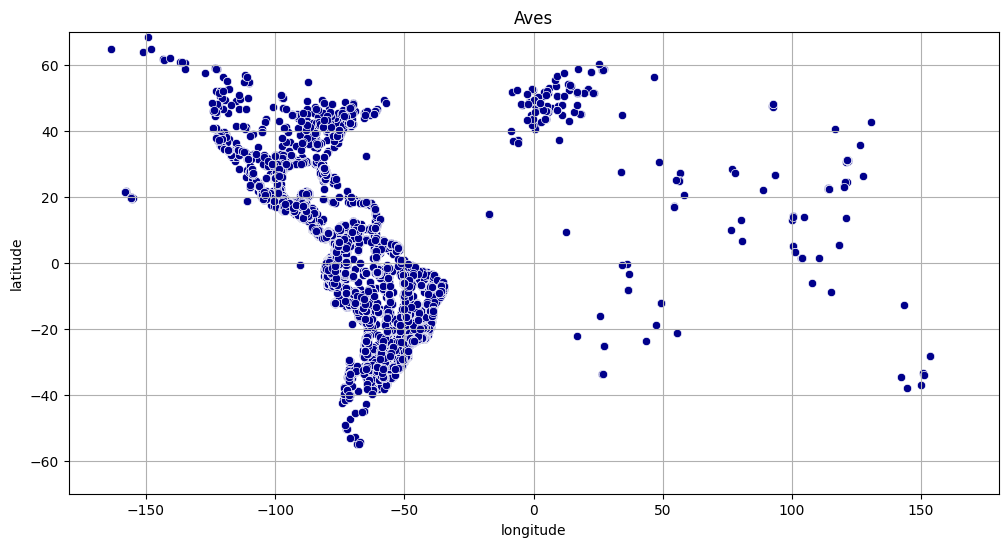

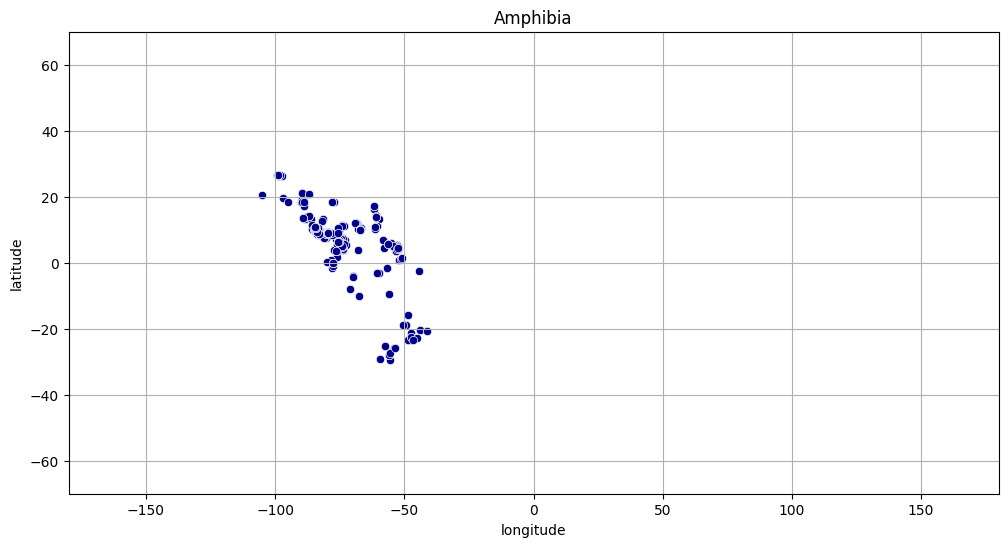

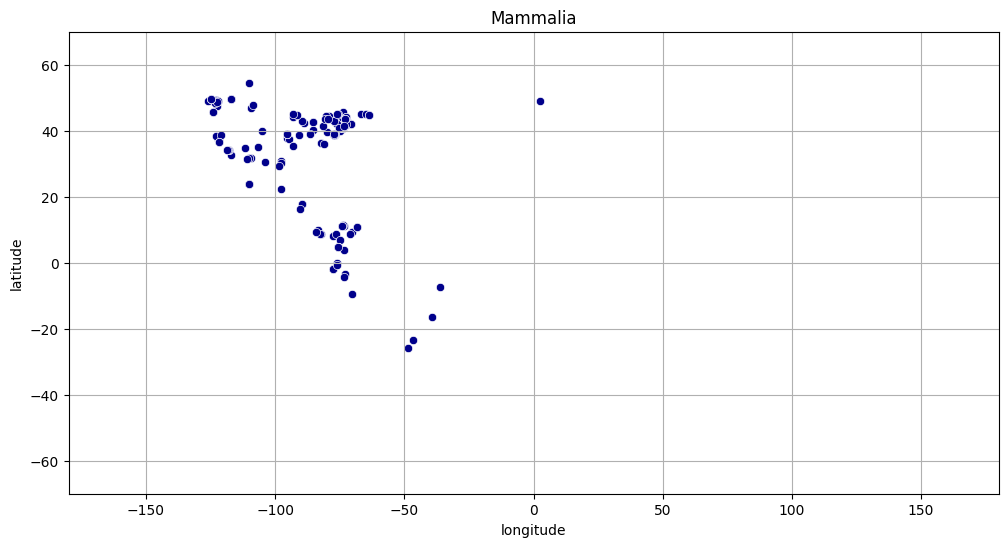

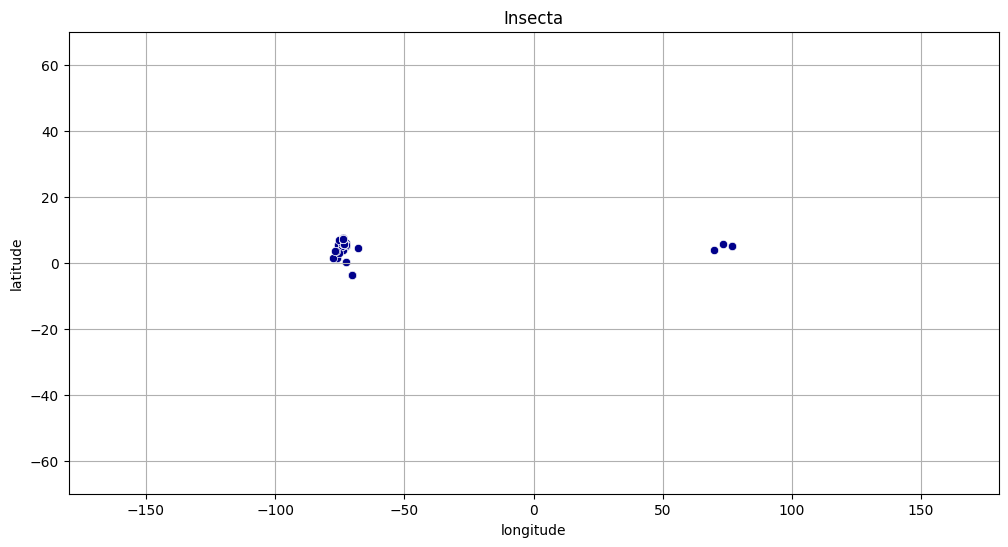

In [67]:
# source - https://www.kaggle.com/code/docxian/birdclef-2025-eda-geography#Static-plots

for c in classes:
    df_select = train_df[train_df.class_name==c]
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df_select, x='longitude', y='latitude', 
                    color='darkblue')
    plt.xlim(-180,180)
    plt.ylim(-70,70)
    plt.title(c)
    plt.grid()
    plt.show()

Looking at these plots we might conclude that geo data should make a difference.

###